In [1]:
import pandas as pd
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import rmse

Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv("../data/MLTollsStackOverflow.csv")
len(df)

132

In [3]:
df.head()

,month,nltk,spacy,stanford-nlp,python,r,numpy,scipy,matlab,machine-learning,...,Plato,Sympy,Flair,stanford-nlp.1,pyqt,Nolearn,Lasagne,OCR,Apache-spark-mlib,azure-virtual-machine
0,09-Jan,0,0,0,631,8,6,2,19,8,...,0,1,0,0,5,0,0,5,0,0
1,09-Feb,1,0,0,633,9,7,3,27,4,...,0,0,0,0,5,0,0,11,0,0
2,09-Mar,0,0,0,766,4,4,2,24,3,...,0,0,0,0,7,0,0,2,0,0
3,09-Apr,0,0,0,768,12,6,3,32,10,...,0,0,0,0,11,0,0,5,0,0
4,09-May,1,0,0,1003,2,7,2,42,7,...,0,0,0,0,10,0,0,3,0,0


In [4]:
print(df['month'][0])
print(df['month'].iloc[-1])

09-Jan
19-Dec


We have a dataset containing monthly question counts for specific topics. The counts start in January 2009 and end in December 2019 totalling in 11 years of data.

### Data Preparation

In [5]:
df['month'] = pd.to_datetime(df['month'], format="%y-%b")
# each column contains the number of questions for a given topic
# we are interested in the total questions asked and need to sum those columns
cols_to_sum = [col for col in df.columns if col != 'month']
df['Total_Questions'] = df[cols_to_sum].sum(axis=1).astype(int)
time_series_df = df.copy()
time_series_df = time_series_df[['month', 'Total_Questions']]
time_series_df.head()

,month,Total_Questions
0,2009-01-01,832
1,2009-02-01,893
2,2009-03-01,1001
3,2009-04-01,1053
4,2009-05-01,1323


In [6]:
len_total_dataset = len(time_series_df)
len_test_dataset = 12 # we want to evaluate the predictions on one year of data
len_train_dataset = len_total_dataset - len_test_dataset

In [7]:
train = time_series_df.iloc[:len_train_dataset]
test = time_series_df.iloc[len_train_dataset:]

### Seasonal Decomposition

In [8]:
from scipy.stats import kruskal
import numpy as np
# Check if there is seasonality in our series
# check the below link for documentation of this function
# https://knk00.medium.com/how-to-determine-seasonality-without-plots-f18cee913b95
def seasonality_test(series):
        seasoanl = False
        idx = np.arange(len(series.index)) % 12
        H_statistic, p_value = kruskal(series, idx)
        if p_value <= 0.05:
            seasonal = True
        return seasonal
seasonality_test(train['Total_Questions'])

True

We can reject the null hypothesis which states that the series is non-seasonal.

<AxesSubplot: xlabel='month'>

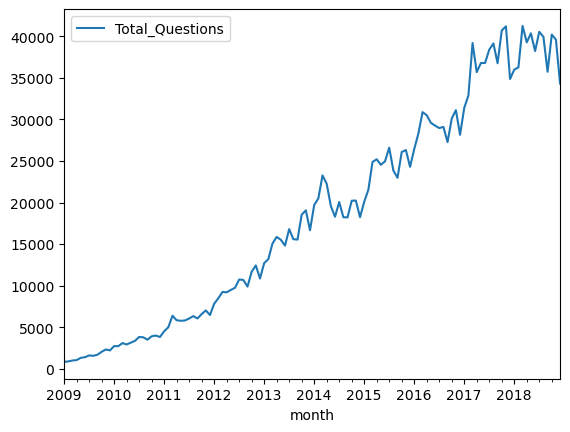

In [9]:
decompose_df = train.set_index('month')
decompose_df.plot()

The above chart shows a rather multiplicative seasonality, meaning we will need to set a specificparameter in the Facebook Prophet function. This also shows in the below chart which contains a detrended time series with increasing amplification with ongoing time.

<AxesSubplot: >

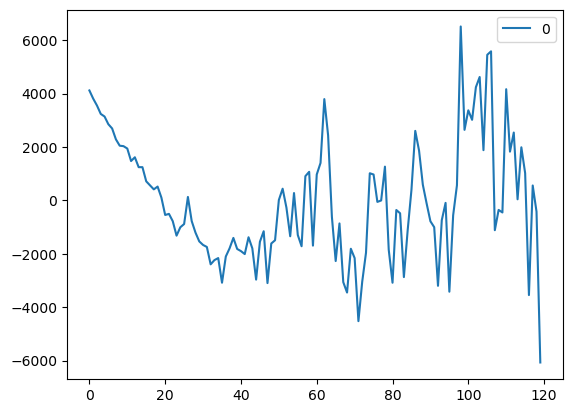

In [10]:
detrended = signal.detrend(decompose_df['Total_Questions'])
detrended_df = pd.DataFrame(detrended)
detrended_df.plot()

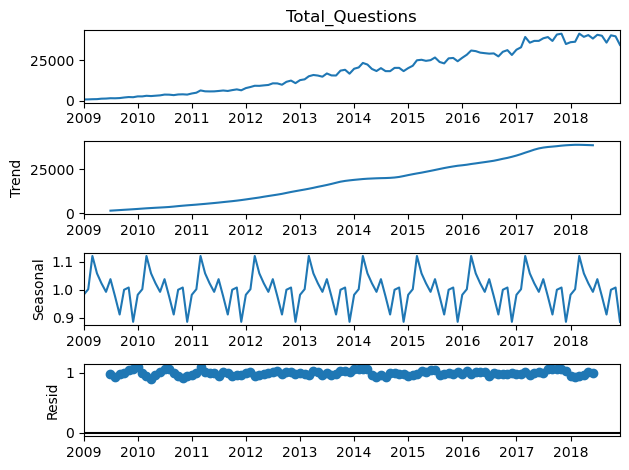

In [11]:
result = seasonal_decompose(decompose_df['Total_Questions'], model='mult')  
result.plot();

## Facebook Prophet

Prophet requires columns to be named in the below way to function

In [12]:
train.columns = ['ds','y']
test.columns = ['ds','y']

22:14:18 - cmdstanpy - INFO - Chain [1] start processing
22:14:18 - cmdstanpy - INFO - Chain [1] done processing


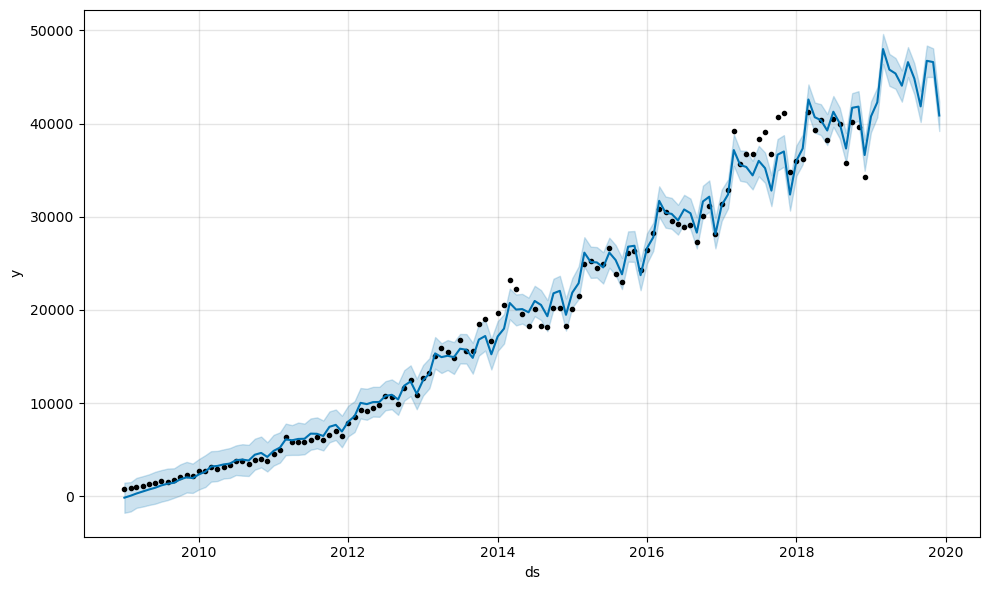

In [13]:
m = Prophet(seasonality_mode='multiplicative') 
m.fit(train)
future = m.make_future_dataframe(12, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast)

In [14]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
127,2019-08-01,45172.844241,43130.141811,46473.540410,45107.046873,45244.915782,-0.007407,-0.007407,-0.007407,-0.007407,-0.007407,-0.007407,0.0,0.0,0.0,44838.227990
128,2019-09-01,45589.389571,40158.894966,43506.847174,45510.023798,45678.608553,-0.082255,-0.082255,-0.082255,-0.082255,-0.082255,-0.082255,0.0,0.0,0.0,41839.420322
129,2019-10-01,45992.497954,44996.142353,48374.146137,45898.690036,46097.310557,0.016133,0.016133,0.016133,0.016133,0.016133,0.016133,0.0,0.0,0.0,46734.474874
130,2019-11-01,46409.043284,45004.529108,48075.404691,46299.798430,46526.813016,0.004117,0.004117,0.004117,0.004117,0.004117,0.004117,0.0,0.0,0.0,46600.114902
131,2019-12-01,46812.151667,39197.039249,42335.788008,46688.516276,46947.359628,-0.127025,-0.127025,-0.127025,-0.127025,-0.127025,-0.127025,0.0,0.0,0.0,40865.818573


In [15]:
test.tail()

,ds,y
127,2019-08-01,45344
128,2019-09-01,43098
129,2019-10-01,52061
130,2019-11-01,51469
131,2019-12-01,44654


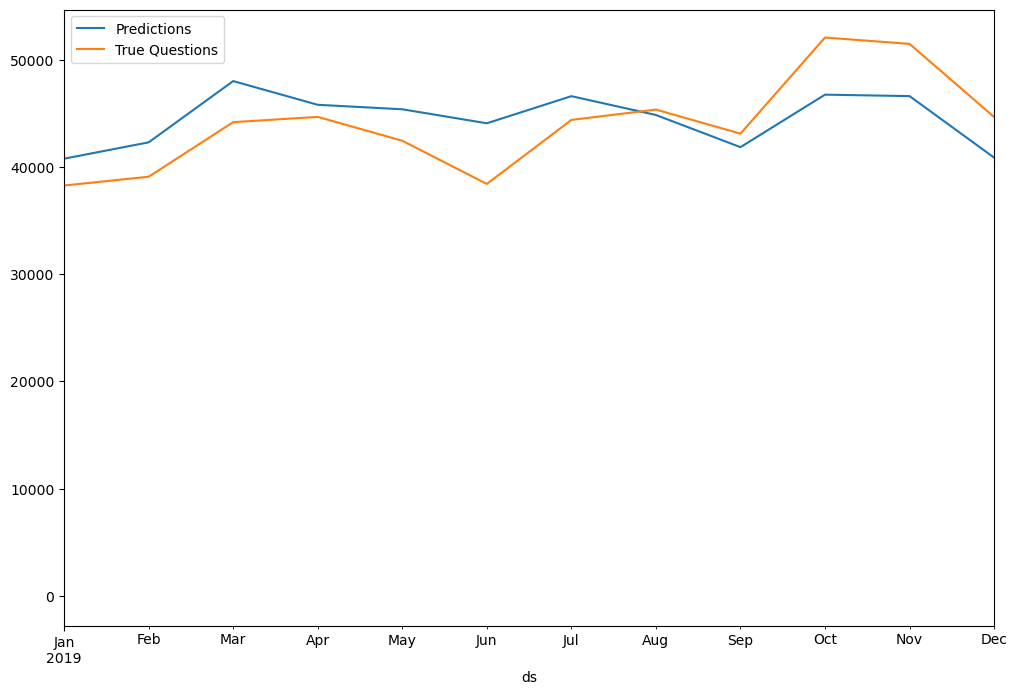

In [16]:
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8))
test.plot(x='ds',y='y',label='True Questions',legend=True,ax=ax,xlim=('2019-01-01','2019-12-01'))
plt.show()

In [17]:
predictions = forecast.iloc[-12:]['yhat']
rmse(predictions,test['y'])

3490.5488788165662

In [18]:
test.mean()

/tmp/ipykernel_51/1706541227.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  test.mean()


y    44002.583333
dtype: float64

In [19]:
rmse(predictions,test['y'])

3490.5488788165662

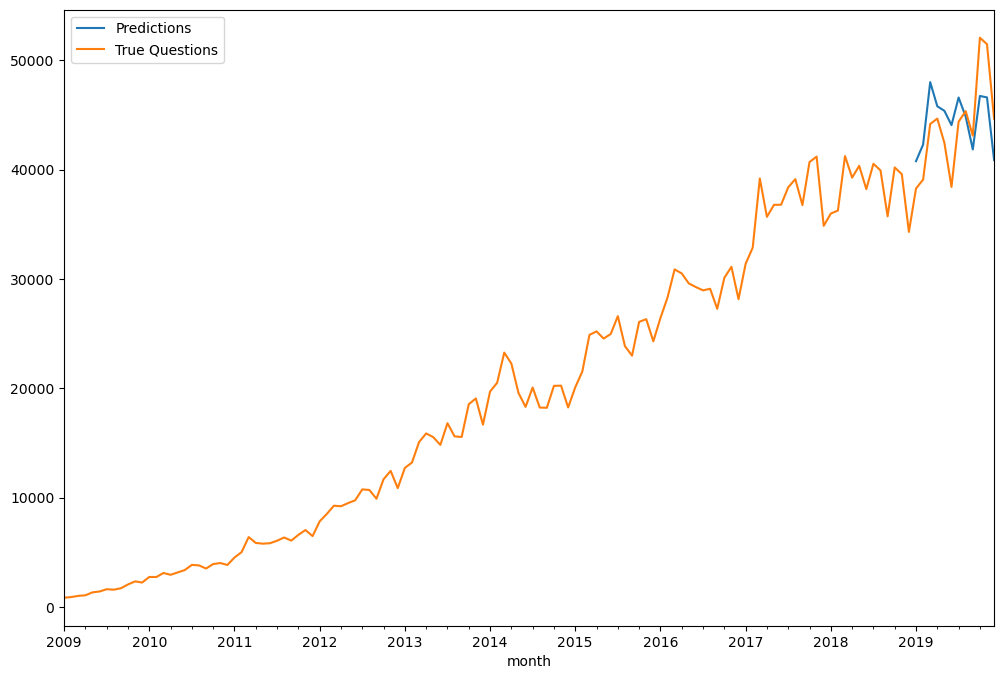

In [20]:
ax = forecast.iloc[-12:].plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8), xlim=('2019-01-01','2019-12-01'))
time_series_df.plot(x='month',y='Total_Questions',label='True Questions',legend=True,ax=ax)
plt.show()

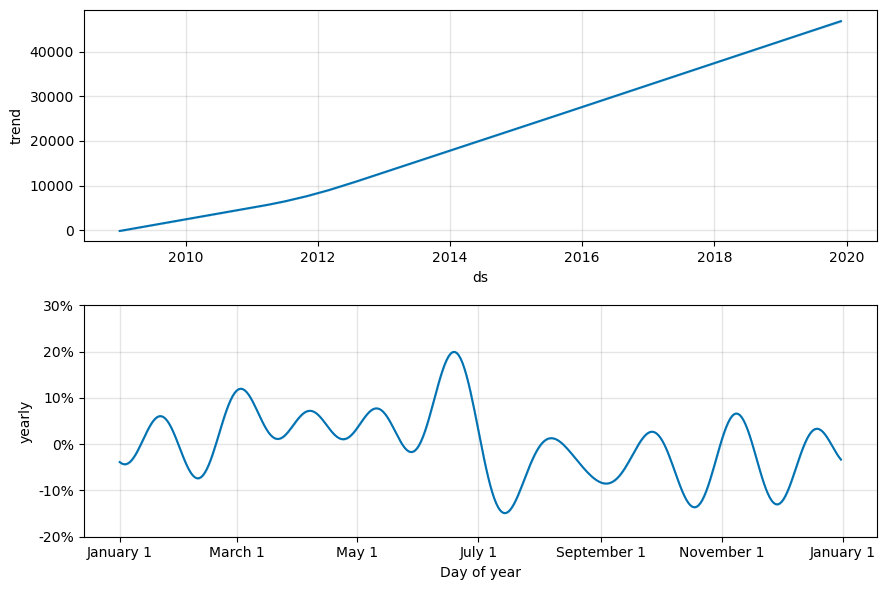

In [21]:
fig = m.plot_components(forecast)

### Interpretation and Recommendations

There are clear spikes in the above Time Series data around mid March, Mid June and Mid September, while there are expected bottoms around Christmas and an unexplained bottom towards the end of May. This bottom would be woth to investigate further.

The recommendations we can make from this depend on the business case. As an example we could recommend increased server capacity around this time, or consider major server upgrades before those downtimes.